In [1]:
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib
import matplotlib.pyplot as plt
import starfile
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import binary_dilation, binary_erosion

In [2]:
# import seaborn and set context for nicer plotting style
import seaborn as sns
sns.set_theme(context='poster', style='ticks', font='Helvetica')

In [3]:
df = starfile.read('../data/particles/HEKFWT_RiboStates_New.star')
optics = df['optics']
df_wt = df['particles']

In [4]:
# are shifts zero?
xshift = df_wt['rlnOriginXAngst']
yshift = df_wt['rlnOriginYAngst']
zshift = df_wt['rlnOriginZAngst']
assert all([c == 0. for c in [xshift.min(), xshift.max(), yshift.min(), yshift.max(), zshift.min(), zshift.max()]])

In [5]:
# get the pixel size and check whether its equal over the list
pixel_size = 1  # in A
if np.all(df_wt['rlnPixelSize'] == df_wt['rlnPixelSize'][0]):
    pixel_size = df_wt['rlnPixelSize'][0]
else:
    print('pixel size not identical over dataset')

In [6]:
# adjust coordinates to A
df_wt['x'], df_wt['y'], df_wt['z'] = df_wt['rlnCoordinateX'] * pixel_size, \
                                     df_wt['rlnCoordinateY'] * pixel_size, \
                                     df_wt['rlnCoordinateZ'] * pixel_size

In this dataset classification information was annotated in the rlnMicrographName columns (see below).

First part of the name is the tomogram identifier, they also contain date information (the ones without date were also collected on the same date). The last three parts of the name indicate active/hibernating, membrane/soluble/uncertain (Mem/Sol/Unk), and if membrane bound also translocon state NCLN/OST/TRAP.

In [7]:
df_wt[::10000]['rlnMicrographName']

0                 tomo1.mrc.tomostar.active.Mem.NCLN
10000      tomo210602_11.mrc.tomostar.active.Mem.OST
20000     tomo210821_294.mrc.tomostar.active.Mem.OST
30000      tomo210813_11.mrc.tomostar.active.Mem.OST
40000      tomo200528_72.mrc.tomostar.active.Mem.OST
50000             tomo66.mrc.tomostar.active.Mem.OST
60000     tomo210821_247.mrc.tomostar.active.Mem.OST
70000          tomo210602_29.mrc.tomostar.active.Sol
80000         tomo210624_120.mrc.tomostar.active.Sol
90000          tomo210813_78.mrc.tomostar.active.Sol
100000         tomo210813_21.mrc.tomostar.active.Unk
110000        tomo210813_125.mrc.tomostar.active.Unk
120000        tomo210730_140.mrc.tomostar.active.Unk
130000         tomo210624_89.mrc.tomostar.active.Unk
Name: rlnMicrographName, dtype: object

We need to split it to extract the information. After splitting, I added these classes as columns to the pandas dataframe.

In [8]:
# ribosome states
df_wt['tomogram'] = [name.split('.')[0] for name in df_wt['rlnMicrographName']]  # first get the tomogram name
df_wt['date'] = [n.split('_')[0] if len(n.split('_')) == 2 else 'tomo' for n in df_wt['tomogram']]
df_wt['activity'] = [name.split('.')[3] for name in df_wt['rlnMicrographName']]
df_wt['membrane'] = [name.split('.')[4] for name in df_wt['rlnMicrographName']]
df_wt['translocon'] = [name.split('.')[5] if len(name.split('.')) == 6 
                            else 'Unk' for name in df_wt['rlnMicrographName']]
df_wt['state'] = [tl if ms == 'Mem' else ms for ms, tl in zip(df_wt['membrane'], df_wt['translocon'])]

Get some additional annotations from other particle lists. Particle identity between lists is matched based on subtomogram name or rotation angle similarity (both are not ideal, but we have to deal with it). This part of the code is a bit custom, but it will be very situational. So, I decided not to wrap it with functions.

This will open lists that were classified based on elongations state and append the information as a new column to the dataframe.

In [14]:
base = '../data/particles/HEKFWT_'
names = ['Dec', 'Post', 'Pre', 'Pre+', 'Rot1', 'Rot1+', 
         'Rot2', 'RotIdle', 'Translocation', 'UnRotIdle']
df_wt['elongation'] = ['Unk', ] * df_wt.shape[0]

for name in names:
    data_temp = starfile.read(base + name + '.star')['particles']
    subt_temp = [subtomo.split('/')[-1] for subtomo in data_temp['rlnImageName']]
    N = len(subt_temp)
    for i, subtomo in enumerate(df_wt['rlnImageName']):
        if subtomo.split('/')[-1] in subt_temp:
            df_wt.loc[i, 'elongation'] = n
            subt_temp.pop(subt_temp.index(subtomo.split('/')[-1]))  # remove the element if we alraedy matched it
    print('freq ' + name + ' : ', (N - len(subt_temp)) / df_wt.shape[0])


freq Dec :  0.20081875697804244
freq Post :  0.10056568663937476
freq Pre :  0.028909564570152587
freq Pre+ :  0.2979903237811686
freq Rot1 :  0.0394491998511351
freq Rot1+ :  0.031231857089691107
freq Rot2 :  0.15303312244138445
freq RotIdle :  0.03387420915519166
freq Translocation :  0.04308894678079643
freq UnRotIdle :  0.05630815035355415


Here we open annotations of presence of the trap and ccdc47 complexes in multipass (NCLN) translocons. I combine the data in a column at the end that has an overview of all different types of translocons and soluble and unassigned states. This is the classification we used for the main figures of the manuscript.

In [15]:
base = '../data/particles/MP_TRAP{trap}CCDC47{ccd}.star'
# a = absent, p = present
names = [('a', 'a'), ('a', 'p'), ('p', 'a'), ('p', 'p')]
df_wt['trapccdc'] = ['Unk', ] * df_wt.shape[0]

for n in names:
    print(n)
    data_temp = starfile.read(base.format(trap=n[0], ccd=n[1]))['particles']
    rot, tilt, psi = data_temp['rlnAngleRot'], data_temp['rlnAngleTilt'], data_temp['rlnAnglePsi']
    for i, (r, t, p) in enumerate(zip(df_wt.rlnAngleRot, df_wt.rlnAngleTilt, df_wt.rlnAnglePsi)):
        # try to find matches of the rotations
        # might be better to do it on positions
        present = np.logical_and(np.logical_and(r == rot, t == tilt), p == psi)
        if np.sum(present) > 1:
            print('not unique')
        elif np.sum(present) == 1:
            df_wt.loc[i, 'trapccdc'] = n[0] + n[1]
#     print('freq ' + n + ' : ', len(subt_temp) / table_wt.shape[0])

trapccdc_dict = {'aa': '', 'ap': 'CCDC47', 'pa': 'TRAP', 'pp': 'TRAPCCDC47'}
comb_state = np.array(['NCLN' + trapccdc_dict[trapccdc] if (st == 'NCLN' and trapccdc != 'Unk') 
                       else st for st, trapccdc in zip(df_wt.state, df_wt.trapccdc)])
df_wt['state_full'] = comb_state

('a', 'a')
('a', 'p')
not unique
not unique
not unique
not unique
('p', 'a')
not unique
not unique
('p', 'p')


In [35]:
# show first few rows to get an idea of the full dataframe
df_wt.head()

,rlnCoordinateX,rlnCoordinateY,rlnCoordinateZ,rlnAngleRot,rlnAngleTilt,rlnAnglePsi,rlnImageName,rlnCtfImage,rlnRandomSubset,rlnPixelSize,...,date,activity,membrane,translocon,state,elongation,trapccdc,state_full,trailing_id,leading_id
0,872.7986,529.7619,286.2439,11.28056,82.88946,181.65190,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,1,6.896,...,tomo,active,Mem,NCLN,NCLN,UnRotIdle,ap,NCLNCCDC47,-1,-1
1,401.9046,214.0999,138.9087,-61.55985,136.25310,-135.14440,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,1,6.896,...,tomo,active,Mem,OST,OST,UnRotIdle,Unk,OST,43744,-1
2,824.8273,699.2300,245.7589,-54.52035,85.32531,102.23010,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,1,6.896,...,tomo,active,Mem,OST,OST,UnRotIdle,Unk,OST,22540,-1
3,854.6401,663.1552,180.3849,135.56340,108.82990,170.21040,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,2,6.896,...,tomo,active,Mem,OST,OST,UnRotIdle,Unk,OST,-1,-1
4,365.4104,783.4767,171.0251,-170.52960,96.45240,78.46428,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,/data2/mgemmer/WARPM/HEKFWT/000_Subtomograms/0...,1,6.896,...,tomo,active,Mem,TRAP,TRAP,UnRotIdle,Unk,TRAP,93748,77732


## Neighbour density

In [16]:
from neighbours import neighbour_position_3d, density_plot, plot_3d

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
relative_coords_mem, plane_norm = neighbour_position_3d(df_wt[df_wt.activity=='active'], 
                                                        class_column_name='state',
                                                        center_classes=['NCLN', 'OST', 'TRAP'],
                                                        neighbour_classes=['NCLN', 'OST', 'TRAP'],
                                                        plane_norm=[0.25, 0.40, 0.88])

you have  61623  particle centers
those have in total  (213017,)  neighbours considering  5  neighbours per particle


In [19]:
# plot in 3d  (warning: slow because of number of points)
# opens interactive plot window
%matplotlib qt 
fig, ax = plot_3d(relative_coords_mem, plane_norm)
plt.show()

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-mchaillet'


In [20]:
relative_coords_mem.T.shape

(213017, 3)

axis tick labels:  [-500, -250, 0, 250, 500]
axis tick labels:  [-500, -250, 0, 250, 500]


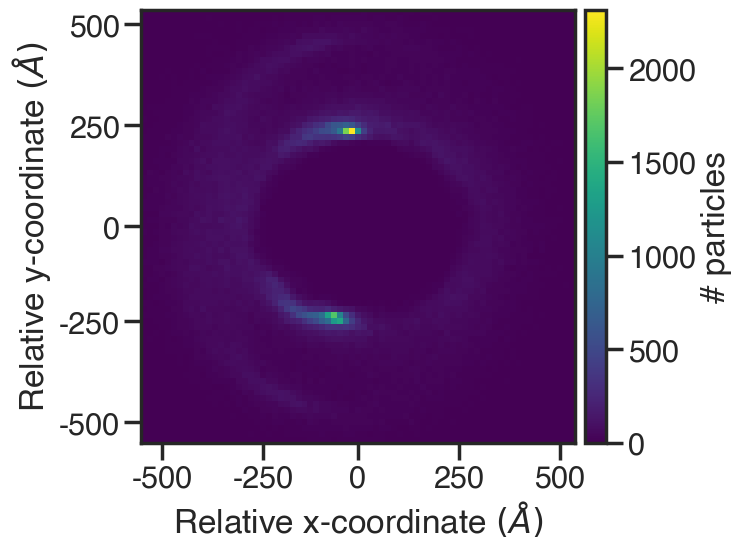

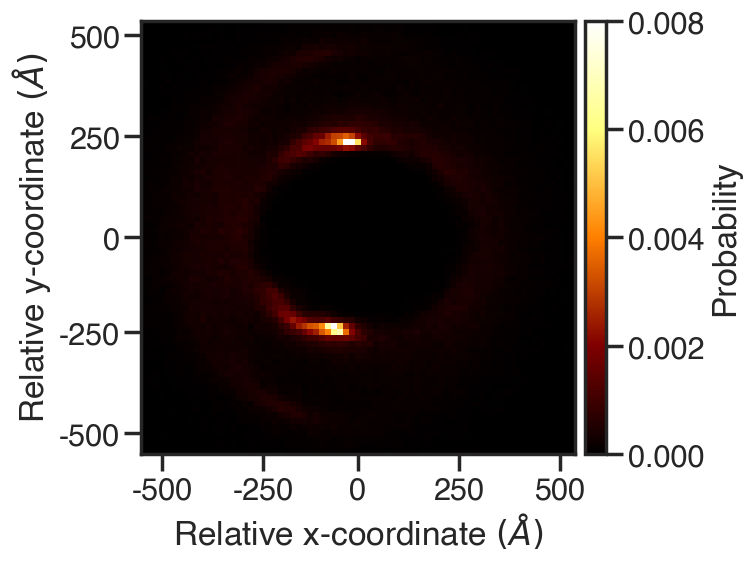

In [21]:
# plot in 2d
# force back to plot in notebook
%matplotlib inline
fig, ax, hist, edges = density_plot(relative_coords_mem, (-550, 550), 15, (6, 6), probability=False, 
                                    tick_labels=[-500, -250, 0, 250, 500], colormap_plt='viridis') #, vrange=(0, 0.008))

# figure can be saved by uncommenting the following line (dpi indicates the resolution):
# plt.savefig('soluble_neighbour_density.png', dpi=300, bbox_inches='tight')


# ====> with the probability and vrange parameters you can adjust the scaling
# - probability option will divide everything by the number of particles
# - with colormap_plt you can select a colorprofile for matplotlib, default is afmhot
#      some options: (https://matplotlib.org/stable/tutorials/colors/colormaps.html)
fig, ax, hist, edges = density_plot(relative_coords_mem, (-550, 550), 15, (6, 6), probability=True, 
                                    tick_labels=[-500, -250, 0, 250, 500], vrange=(0, 0.008), colormap_plt='afmhot')

Now we look at the density distribution of the soluble ribosomes. With the `class_column_name`, `center_classes`, and `neighbour_class` parameters you can specify which classifier to select some groups from. This way you could compare the density of soluble ribosomes around NCLN translocons (for example). Now I use it to check the density of soluble ribosomes around other soluble ribos. In the previous plots I used it to check the density of membrane bround ribos around other membrane bound.

In [22]:
relative_coords_sol, plane_norm = neighbour_position_3d(df_wt[df_wt.activity=='active'], class_column_name='state', 
                                                    center_classes=['Sol'],
                                                    neighbour_classes=['Sol'],
                                                    plane_norm=[0.25, 0.40, 0.88])

you have  23188  particle centers
those have in total  (37245,)  neighbours considering  5  neighbours per particle


axis tick labels:  [-500, -250, 0, 250, 500]


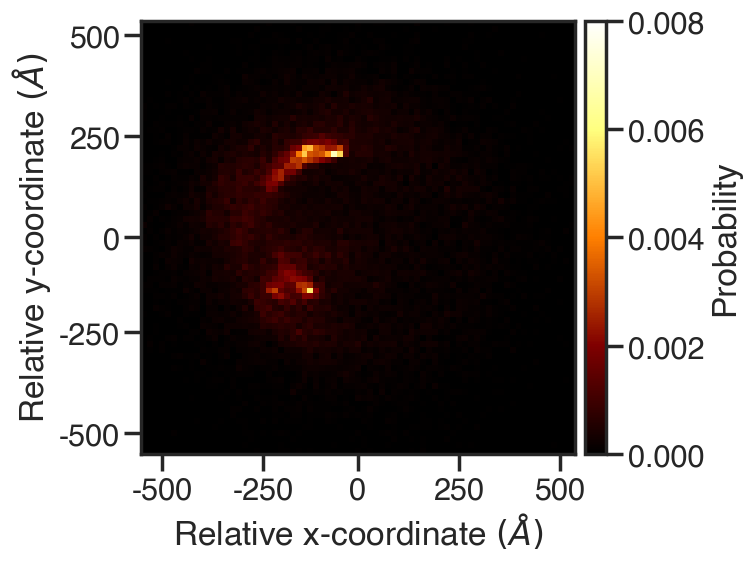

In [23]:
%matplotlib inline
fig, ax, hist, edges = density_plot(relative_coords_sol, (-550, 550), 15, (6, 6), probability=True, 
                                    tick_labels=[-500, -250, 0, 250, 500], vrange=(0, 0.008))

In [24]:
relative_coords_inact, plane_norm = neighbour_position_3d(df_wt[df_wt.activity!='active'], plane_norm=[0.25, 0.40, 0.88])

you have  12090  particle centers
those have in total  (27254,)  neighbours considering  5  neighbours per particle


axis tick labels:  [-500, -250, 0, 250, 500]


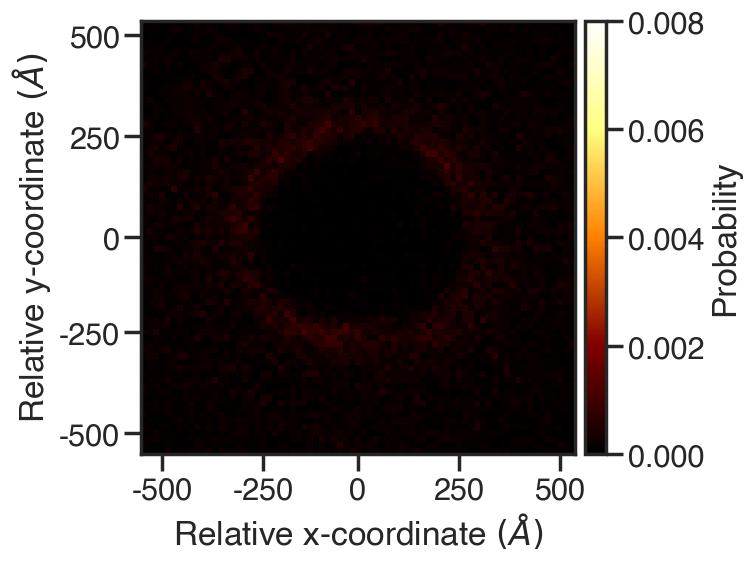

In [25]:
%matplotlib inline
fig, ax, hist, edges = density_plot(relative_coords_inact, (-550, 550), 15, (6, 6), probability=True, 
                                    tick_labels=[-500, -250, 0, 250, 500], vrange=(0, 0.008))

## Polysome masks

For membrane-bound and soluble ribos there are distinct spots in the neighbour density. These spots correspond to the binding mode of polysomes. mRNA weaves through the ribosome in a clear direction from 5' to 3' end. Based on the arrangment of the reference in the neighbour density plots we know that the bottom clusters correspond to polysome neighbour towards the leading end of the mRNA chain, while the top cluster belong to neighbours on the trailing end.

Numpy can calculate histogram of multidimensional data with following function

`np.histogramdd()`

Array needs to be (N, D), where N is number of samples and D number of dimensions. In this case D == 3, for x, y, z.

**NOTE** we use `relative_coords_mem` and `relative_coords_sol` that we calculated above for the neighbour density. Make sure to run the cells above.

In [26]:
import mrcfile


def write(filename, data, voxel_size, overwrite=True):
    with mrcfile.new(filename, overwrite=overwrite) as mrc:
        mrc.set_data(data.T)  # mrcfile stores as zyx, and here i assume xyz (=> same a pytom)
        mrc.voxel_size = voxel_size


def read(filename):
    with mrcfile.open(filename) as mrc:
        data = mrc.data.T  # same tranpose back to xyz
        voxel_size = mrc.voxel_size
    return data, voxel_size
        

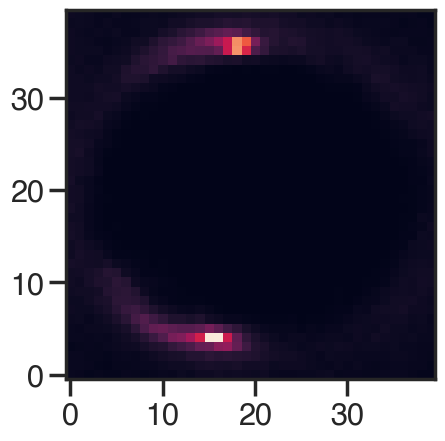

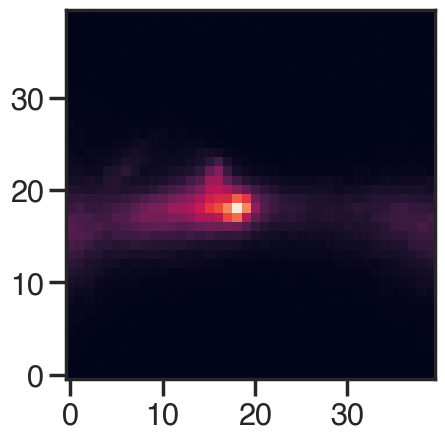

In [27]:
%matplotlib inline
hist_voxel_size = 15
vrange = (-300, 300)
n_bins = int(abs(vrange[0] - vrange[1]) / hist_voxel_size)
hist_3d, hist_3d_edges = np.histogramdd(relative_coords_mem.T, bins=n_bins, range=[(-300, 300), ] * 3, density=False)
hist_3d /= hist_3d.sum()

# imshow takes array (M,N) as rows, columns, tranpose to get x as columns because input is (X,Y)
plt.imshow(hist_3d.sum(axis=2).T, origin='lower')  
plt.show()

plt.imshow(hist_3d.sum(axis=1).T, origin='lower')
plt.show()

mask = binary_dilation((hist_3d > 0.0003) * 1, iterations=2).astype(np.float32)

# cut in y to separate clusters (y axis goes from 0 to N from top to bottom, can be counterintuitive)
leading_mask = mask.copy()
leading_mask[:, mask.shape[1]//2: ,:] = 0
trailing_mask = mask.copy()
trailing_mask[:, 0:mask.shape[1]//2, :] = 0

# write('3dhist_WT_membrane.mrc', hist_3d)
write('../data/results/3dhist_WT_membrane_mask.mrc', mask, hist_voxel_size)
write('../data/results/3dhist_WT_membrane_mask_leading.mrc', leading_mask, hist_voxel_size)
write('../data/results/3dhist_WT_membrane_mask_trailing.mrc', trailing_mask, hist_voxel_size)

x, y, z = hist_3d_edges  # these contain information on the position of the bins in xyz

np.save('../data/results/3dhist_WT_membrane_mask_x.npy', x)
np.save('../data/results/3dhist_WT_membrane_mask_y.npy', y)
np.save('../data/results/3dhist_WT_membrane_mask_z.npy', z)

# index with: np.searchsorted(x, -284) - 1

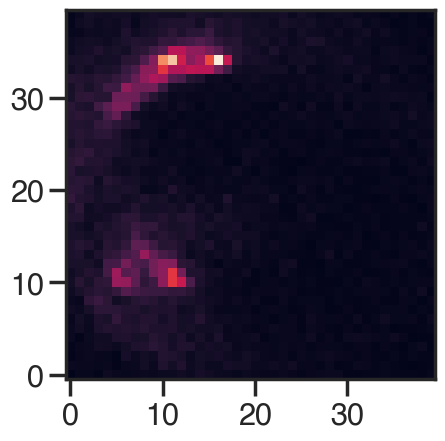

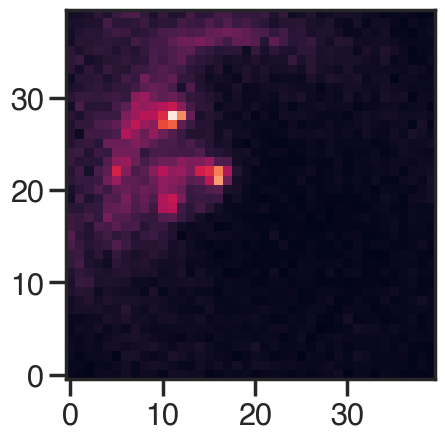

In [28]:
%matplotlib inline
hist_voxel_size = 15
vrange = (-300, 300)
n_bins = int(abs(vrange[0] - vrange[1]) / hist_voxel_size)
hist_3d, hist_3d_3dges = np.histogramdd(relative_coords_sol.T, bins=n_bins, range=[(-300, 300), ] * 3, density=False)
hist_3d /= hist_3d.sum()

# plt.imshow(np.rot90(hist_3d.sum(axis=2)))
plt.imshow(hist_3d.sum(axis=2).T, origin='lower')  
plt.show()

plt.imshow(hist_3d.sum(axis=1).T, origin='lower')
plt.show()

mask = binary_dilation((hist_3d > 0.0005) * 1, iterations=2).astype(np.float32)  # float32 for mrcfile

# cut in y to separate clusters (y axis goes from 0 to N from top to bottom, can be counterintuitive)
leading_mask = mask.copy()
leading_mask[:, mask.shape[1]//2:, :] = 0
trailing_mask = mask.copy()
trailing_mask[:, 0:mask.shape[1]//2:, :] = 0

# write('3dhist_WT_soluble.mrc', hist_3d)
write('../data/results/3dhist_WT_soluble_mask.mrc', mask, hist_voxel_size)
write('../data/results/3dhist_WT_soluble_mask_leading.mrc', leading_mask, hist_voxel_size)
write('../data/results/3dhist_WT_soluble_mask_trailing.mrc', trailing_mask, hist_voxel_size)

x, y, z = hist_3d_edges  # these contain information on the position of the bins in xyz

np.save('../data/results/3dhist_WT_soluble_mask_x.npy', x)
np.save('../data/results/3dhist_WT_soluble_mask_y.npy', y)
np.save('../data/results/3dhist_WT_soluble_mask_z.npy', z)

Here I combine the membrane and soluble mask to create general trailing/leading masks for the entire dataset.

In [29]:
leading1, vs = read('../data/results/3dhist_WT_soluble_mask_leading.mrc')
leading2, vs = read('../data/results/3dhist_WT_membrane_mask_leading.mrc')
write('../data/results/3dhist_WT_mask_leading.mrc', ((leading1 + leading2 > 0) * 1).astype(np.float32), vs)

trailing1, vs = read('../data/results/3dhist_WT_soluble_mask_trailing.mrc')
trailing2, vs = read('../data/results/3dhist_WT_membrane_mask_trailing.mrc')
write('../data/results/3dhist_WT_mask_trailing.mrc', ((trailing1 + trailing2 > 0) * 1).astype(np.float32), vs)

## Find trailing/leading neighbours over the dataset

In [30]:
from neighbours import find_leading_trailing

In [34]:
leading_mask, _ = read('../data/results/3dhist_WT_mask_leading.mrc')
trailing_mask, _ = read('../data/results/3dhist_WT_mask_trailing.mrc')
# these bounds are the same for all the masks
mask_bounds = (np.load('../data/results/3dhist_WT_membrane_mask_x.npy'), 
               np.load('../data/results/3dhist_WT_membrane_mask_y.npy'), 
               np.load('../data/results/3dhist_WT_membrane_mask_z.npy'))

# TODO test should be replaced with df_wt
df_wt, poly, non_poly = find_leading_trailing(df_wt, trailing_mask, leading_mask, mask_bounds, neighbourhood=4, 
                             plane_norm=[0.25, 0.40, 0.88])

In [37]:
poly.shape

(0,)

In [36]:
# plot to confirm we selected the right ones
density_plot(poly, (-300, 300), 15, (6, 6), probability=True)
plt.show()
density_plot(non_poly, (-300, 300), 15, (6, 6), probability=True)
plt.show()

AssertionError: data does not have x, y, z as the second axis

In [ ]:
# annotate the table with trailing and leading class information
df_wt['tr_state_full'] = [table_wt.loc[i, 'state_full'] if i >= 0 else 'non' for i in table_wt.trailing_id]
df_wt['ld_state_full'] = [table_wt.loc[i, 'state_full'] if i >= 0 else 'non' for i in table_wt.leading_id]
df_wt['tr_elongation'] = [table_wt.loc[i, 'elongation'] if i >= 0 else 'non' for i in table_wt.trailing_id]
df_wt['ld_elongation'] = [table_wt.loc[i, 'elongation'] if i >= 0 else 'non' for i in table_wt.leading_id]